In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

## Preprocessing to get mean & std of images

In [2]:
pre_transform = transforms.Compose([
        transforms.ToTensor()
])

In [3]:
predataset = torchvision.datasets.CIFAR10(root ='dataset/preprocess/train', 
                                        train = True,
                                        download = True, 
                                        transform = pre_transform)

Files already downloaded and verified


In [4]:
print(predataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset/preprocess/train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
predataloader = torch.utils.data.DataLoader(predataset, 
                                         batch_size=16, shuffle=True, 
                                         num_workers=2)

In [6]:
pop_mean = []
pop_std = []
for i, data in enumerate(predataloader): 
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

In [7]:
pop_mean = np.array(pop_mean)
pop_std = np.array(pop_std)
print(pop_mean.shape)
print(pop_std.shape)

(3125, 3)
(3125, 3)


In [8]:
pop_mean = pop_mean.mean(axis=0)
pop_std = pop_std.mean(axis=0)
print(pop_mean)
print(pop_std)

[0.49139938 0.48215815 0.4465311 ]
[0.24436055 0.24084    0.25819105]


## Preparing the input dataset

In [11]:
train_transform = transforms.Compose([
        transforms.Resize(32), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(pop_mean, pop_std)
])

test_transform = transforms.Compose([
        transforms.Resize(32), 
        transforms.ToTensor(), 
        transforms.Normalize(pop_mean, pop_std)
])

In [12]:
trainset = torchvision.datasets.CIFAR10(root ='dataset/postprocess/train', 
                                        train = True,
                                        download = True, 
                                        transform = train_transform)

testset = torchvision.datasets.CIFAR10(root ='dataset/postprocess/test', 
                                        train = False,
                                        download = True, 
                                        transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = 16, 
                                          shuffle = True, 
                                          num_workers = 2)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = 16, 
                                         shuffle = False, 
                                         num_workers = 2)

print(trainloader)

Next, looking at the classes into which the images in the `trainset` can be categorized. 

In [47]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Labels are numeric values that correspond to the classnames. 

In [49]:
label

tensor([1, 1, 6, 7, 5, 7, 4, 9, 3, 9, 9, 4, 8, 3, 3, 6])

## Defining the DNN architecture

In [57]:
in_size = 3

hid1_size = 16
hid2_size = 32

out1_size = 400
out2_size = 10

k_conv_size = 5

In [77]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size), 
            nn.BatchNorm2d(hid1_size), 
            nn.ReLU(), 
            # nn.ELU() # Exponential Linear Unit
            nn.MaxPool2d(kernel_size = 2))
            ## nn.AvgPool2d(kernel_size = 2))
            ## nn.LPPool2d(1, kernel_size = 2))
            ## LPPool is a 2D power average pooling
            ## Takes input parameter p
            ## p = infinity => Max Pooling
            ## p = 1 => Average Pooling
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), 
            nn.BatchNorm2d(hid2_size), 
            nn.ReLU(), 
            # nn.ELU() 
            nn.MaxPool2d(kernel_size = 2))
        
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size), 
            nn.ReLU(), 
            # nn.ELU()
            nn.Dropout(0.5), 
            nn.Linear(out1_size, out2_size))
        
    def forward(self, x):

        out = self.layer1(x)
        # print(out.shape)

        out = self.layer2(out)
        # print(out.shape)

        out = out.reshape(out.size(0), -1)
        # print(out.shape)

        out = self.layer3(out)
        # print(out.shape)

        return F.log_softmax(out, dim = -1)


model = ConvNet()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

Set up the parameters to train the model. 

## Training the model with trainset

In [59]:
learning_rate = 0.001

loss_criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr = learning_rate)

In [60]:
total_step = len(trainloader)
num_epochs = 10
loss_values = list()

In [61]:
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        
        outputs = model(images)
        loss = loss_criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}],', 
                  f'Step [{i + 1}/{total_step}],', 
                  f'Loss: {loss.item()}')
            loss_values.append(loss.item())

print('Training finished')
        

Epoch [1/10], Step [1000/3125], Loss: 1.3280588388442993
Epoch [1/10], Step [2000/3125], Loss: 1.0543204545974731
Epoch [1/10], Step [3000/3125], Loss: 1.217220664024353
Epoch [2/10], Step [1000/3125], Loss: 0.8617454767227173
Epoch [2/10], Step [2000/3125], Loss: 1.539162516593933
Epoch [2/10], Step [3000/3125], Loss: 0.8273030519485474
Epoch [3/10], Step [1000/3125], Loss: 0.7677850723266602
Epoch [3/10], Step [2000/3125], Loss: 0.8205744028091431
Epoch [3/10], Step [3000/3125], Loss: 1.0069185495376587
Epoch [4/10], Step [1000/3125], Loss: 1.4483381509780884
Epoch [4/10], Step [2000/3125], Loss: 1.0281654596328735
Epoch [4/10], Step [3000/3125], Loss: 1.4514272212982178
Epoch [5/10], Step [1000/3125], Loss: 1.2952697277069092
Epoch [5/10], Step [2000/3125], Loss: 0.9368324279785156
Epoch [5/10], Step [3000/3125], Loss: 0.9838365912437439
Epoch [6/10], Step [1000/3125], Loss: 1.024109125137329
Epoch [6/10], Step [2000/3125], Loss: 0.79458087682724
Epoch [6/10], Step [3000/3125], Loss

Text(0, 0.5, 'Loss')

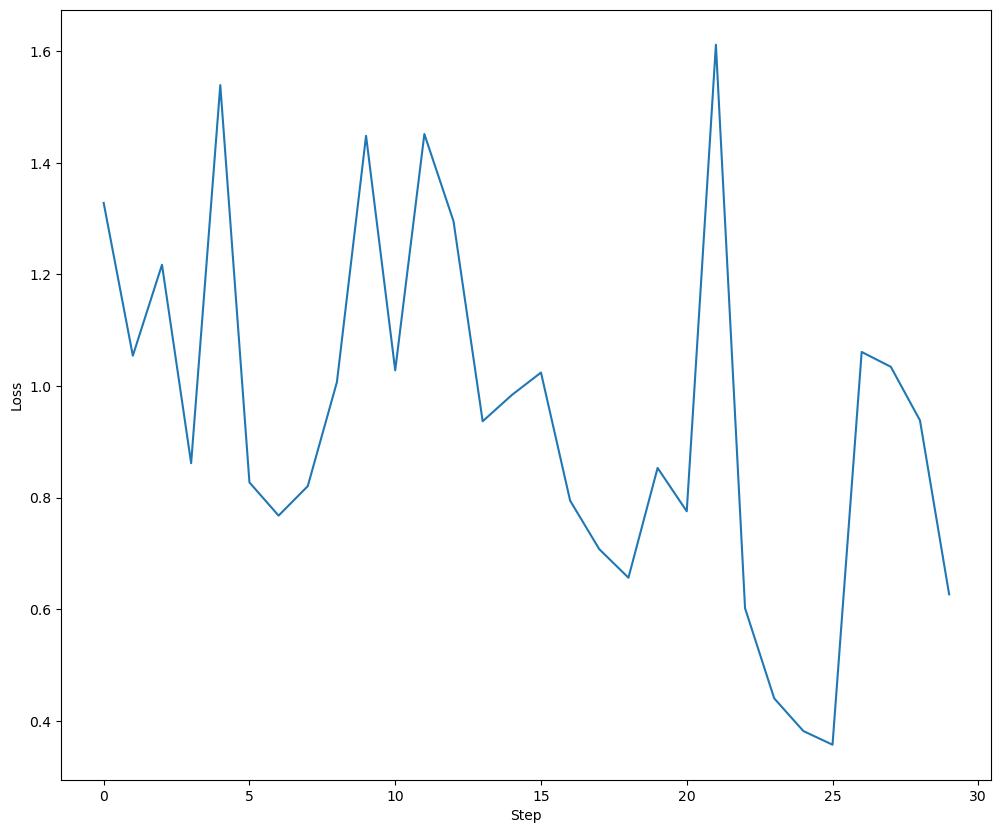

In [62]:
x = range(len(loss_values))

plt.figure(figsize = (12, 10))
plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

## Evaluating the model performance

In [63]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in testloader:
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f'Accuracy of model on 10K images: {100 * correct/total}%') 

Accuracy of model on 10K images: 72.65%


Making a prediction using the model on a sample image picked up from the test dataset. 

## Predicting a random sample of image

In [50]:
randidx = np.random.randint(low=0, 
                            high=len(testset), 
                            size=1)[0]
sample_img, img_label = testset[randidx]
#sample_img, img_label = testset[23]
print(f'Image Label: {img_label} => Image Class: {class_names[img_label]}')
print(sample_img.shape)

Image Label: 8 => Image Class: ship
torch.Size([3, 32, 32])


This is a $32$ x $32$ image with the channel information $(3)$ as the first dimension. We need to transpose the axes of this image so that the channel info is at the end of the dimensions, if we want to plot it in matplotlib.

In [51]:
sample_img = np.transpose(sample_img, (1, 2, 0))
print(sample_img.shape)

torch.Size([32, 32, 3])


Also, rescale the image such that the pixel values are between 0 and 1 and centered at 0.5.

In [52]:
m, M = sample_img.min(), sample_img.max()
sample_img = (1/(abs(m) * M)) * sample_img + 0.5

Plot the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


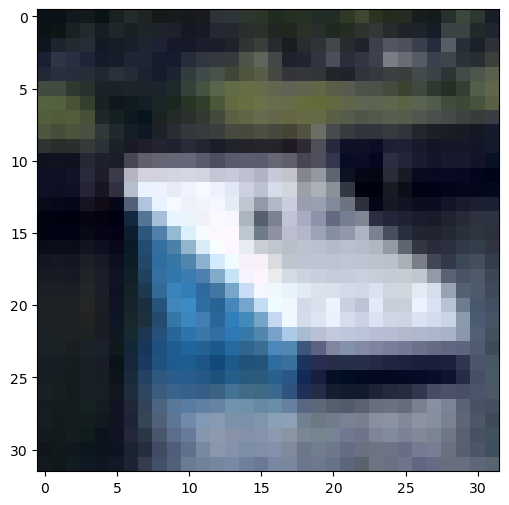

In [53]:
plt.figure(figsize = (6, 6))
plt.imshow(sample_img)

Extracting this random image again as test image. Also, reshape this test image in a format (or dimensions) that our model expect - batch, channels, height, width. 

In [64]:
test_img, test_label = testset[randidx]
test_img = test_img.reshape(-1, 3, 32, 32)

Now, using the trained model to predict the test image. `out_predict` returns a tensor of softmax values of length $10$, since we have $10$ classes, and also because the output layer of the Fully Connected Layer has $10$ nodes.   
The index of maximum of these softmax values (argmax) is the predicted class. 

In [73]:
out_predict = model(test_img)
_, predicted = torch.max(out_predict.data, 1)

In [75]:
print(f'Actual label: {test_label}', 
      '\n', 
      f'Predicted label: {predicted.item()}')

Actual label: 8 
 Predicted label: 8
